In [1]:
import pandas as pd
import numpy  as np
import seaborn as sns

from scipy import stats
from math  import ceil
from statsmodels.stats import power, proportion

from matplotlib import pyplot as plt
from locale import currency, setlocale, getlocale, LC_ALL

setlocale(LC_ALL, getlocale());

#### 0.1. Load Dataset

In [3]:
df_raw = pd.read_csv('../data/ab_data_james.csv')

In [4]:
df_raw.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## 1.0. Descriptive Statistical

In [5]:
df1 = df_raw.copy()

### 1.1. Rename Columns

In [6]:
df1.columns.tolist() # snake_case format

['user_id', 'timestamp', 'group', 'landing_page', 'converted']

### 1.2. Data Dimension

In [7]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 294478
Number of Columns: 5


### 1.3. Change Data Types

In [8]:
df1['timestamp'] = pd.to_datetime(df1['timestamp'])

### 1.4. Check Null Values

In [9]:
df1.isna().sum() / len(df1)

user_id         0.0
timestamp       0.0
group           0.0
landing_page    0.0
converted       0.0
dtype: float64

### 1.5. Fillout Null Values

1. Do not have Null Values on Dataset

### 1.6. Descriptive Statistical

In [10]:
num_att = df1.select_dtypes(include=['int64', 'float64'])
num_att.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,294478.0,787974.124733,91210.823776,630000.0,709032.25,787933.5,866911.75,945999.0
converted,294478.0,0.119659,0.324563,0.0,0.00,0.0,0.00,1.0


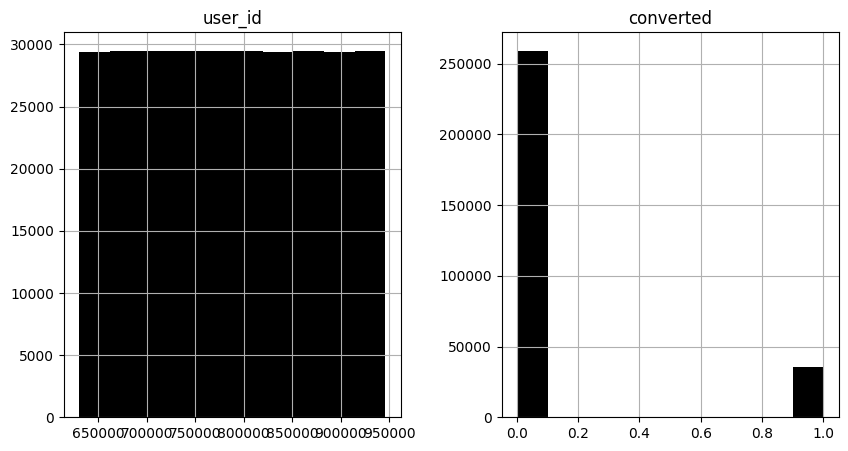

In [11]:
num_att.hist(figsize=(10,5), color='black');

#### 1.6.2. Categorical Features

In [ ]:
df1.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
group,294478,2,treatment,147276
landing_page,294478,2,old_page,147239


In [ ]:
pd.crosstab(df1['group'], df1['converted'])

converted,0,1
group,,
control,129479,17723
treatment,129762,17514


In [ ]:
duplicated_users = df1[df1.user_id.duplicated()]
duplicated_users.head(2)

,user_id,timestamp,group,landing_page,converted
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


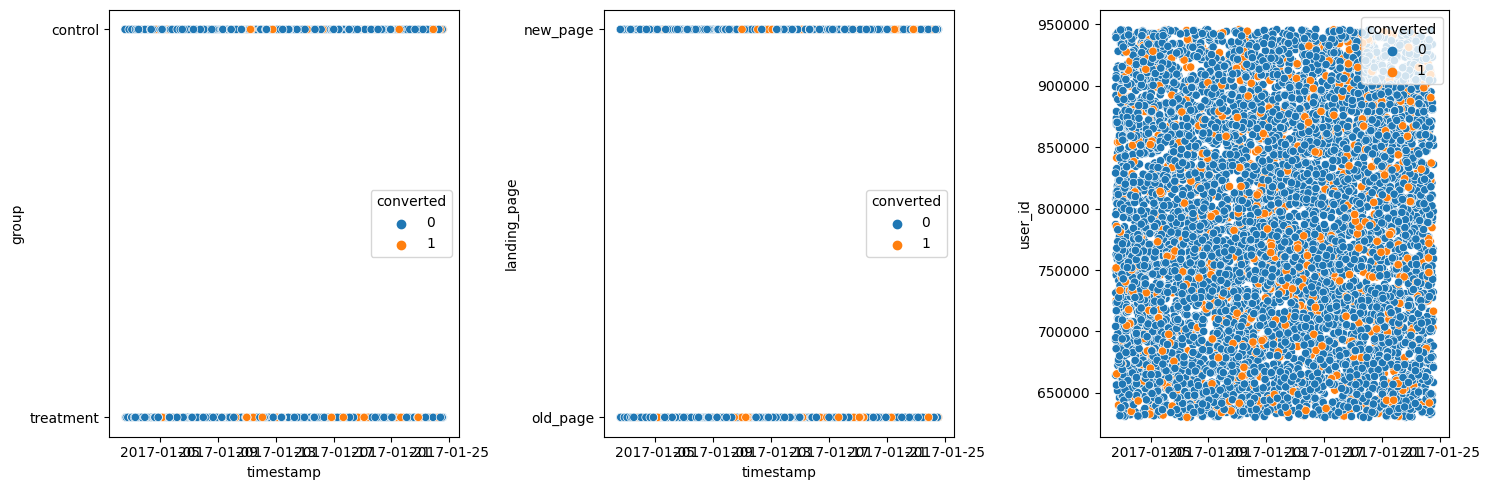

In [ ]:
aux = df1[df1.user_id.isin(duplicated_users.user_id)]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax = ax.flatten()
for i, col in zip(range(0, 2), ['group', 'landing_page']):
    sns.scatterplot(x=aux.timestamp, y=aux[col], hue=aux.converted, ax=ax[i])
sns.scatterplot(x=aux.timestamp, y=aux.user_id, hue=aux.converted, ax=ax[-1])
plt.tight_layout()

In [ ]:
print("Max Date:", df1.timestamp.max())
print("Min Date:", df1.timestamp.min())

print("Simulation total time:", (df1.timestamp.max() - df1.timestamp.min()))

Max Date: 2017-01-24 13:41:54.460509
Min Date: 2017-01-02 13:42:05.378582
Simulation total time: 21 days 23:59:49.081927


## 2.0. Dataset Filtering

In [10]:
df2 = df1.copy()

In [13]:
users_to_drop = df2[['converted', 'user_id']].groupby('user_id').count().reset_index().query('converted > 1')['user_id']

df2 = df2[~df2['user_id'].isin(users_to_drop)].reset_index(drop=True)

In [14]:
pd.crosstab(df2['group'], df2['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


In [15]:
# Checking Group Homogenity ( If have more columns )

df2[['group', 'landing_page', 'user_id']].groupby(['group', 'landing_page']).count().reset_index()

,group,landing_page,user_id
0,control,new_page,1928
1,control,old_page,145274
2,treatment,new_page,145311
3,treatment,old_page,1965


## 3.0. Experiment Design

#### 3.1. Hypothesis Formulation

**Ho.:** New Page convert 12% for sale of specific keyboard.

**Hi.:** New page will convert more than 12% or more for salve of specific keyboard.

#### 3.2. Experiment Parameters

In [4]:
# Type I Error
confidence_level = .95
significance_level = .05

# Expected Conversions
## quo status is the older events conversion (example: older 6 months).
## new expected conversion is the new business objective of the conversion. 
quo_status_conversion = .13
new_expected_conversion = .15

# Type II Error
stats_power = .8

# Effect size for binary (proportion effect) test
# Based on Cohen Book, do not exists "negative" effect size** 
effect_size = proportion.proportion_effectsize(quo_status_conversion, new_expected_conversion)
manual_formula_effect_size = 2*(np.arcsin((new_expected_conversion**(1/2))) - np.arcsin((quo_status_conversion**(1/2)))) # Positive Version

In [5]:
print(f"Proportion Statsmodels effect size: {effect_size}")
print(f"Proportion Manual Formula effect size: {manual_formula_effect_size}")

Proportion Statsmodels effect size: -0.0576728617308947
Proportion Manual Formula effect size: 0.0576728617308947


In [6]:
# Statistical Power calculations for z-test for two independent samples.
# Used for two proportions -> Can use TTestIndPower based on other experiments

power_info = power.NormalIndPower()

In [17]:
n = ceil(
        power_info.solve_power(
            power=stats_power,
            effect_size=manual_formula_effect_size,
            alpha=significance_level,
    )
)

In [18]:
print(f'Total samples for Treatment and Control: {n*2}')
print(f'Total samples for Treatment: {n}')
print(f'Total samples for Control: {n}')

Total samples for Treatment and Control: 9440
Total samples for Treatment: 4720
Total samples for Control: 4720


##### 3.2.1. N Samples in N Examples

In [ ]:
quo_status_conversion = .13

n_examples_list = {}
for proportion_expected in np.arange(0.10, 0.20, 0.01):
    if not proportion_expected == .13:
        effect_size = proportion.proportion_effectsize(quo_status_conversion, proportion_expected)
        n = ceil(
            power_info.solve_power(
                power=stats_power,
                effect_size=effect_size,
                alpha=significance_level,
            )
        )

        n_examples_list[proportion_expected] = n

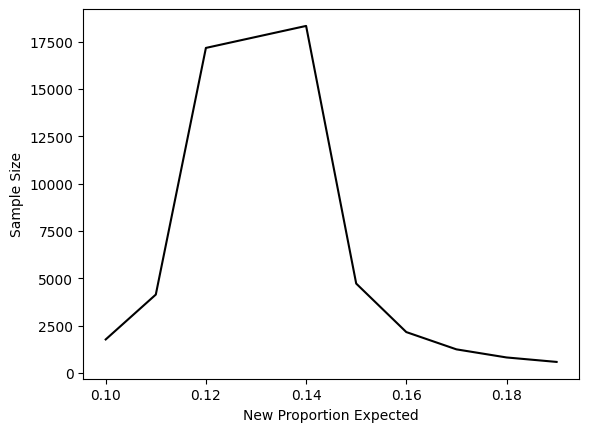

In [ ]:
a = sns.lineplot(x=n_examples_list.keys(), y=n_examples_list.values(), color="k")
a.set_xlabel('New Proportion Expected')
a.set_ylabel('Sample Size');
# Min sample for this exacts proportions ?

#### 3.3. Sampling Strategy

This step in real life is not "necessary".

In [18]:
df_control = df2[df2['group'] == 'control'].sample(n, random_state=321)
df_treatment = df2[df2['group'] == 'treatment'].sample(n, random_state=321)

df_ab = pd.concat([df_control, df_treatment])

In [19]:
pd.crosstab(df_ab['group'], df_ab['landing_page'])

landing_page,new_page,old_page
group,,
control,0,4720
treatment,4720,0


#### 3.4. Calculate control & treatment explicity metric

In [20]:
df_converted = df_ab[df_ab['converted'] == 1]

print(f"Total conversion on two experiments: {df_converted.shape[0] / len(df_ab):.4f}")

Total conversion on two experiments: 0.1225


In [21]:
conversion_control = df_control[df_control['converted'] == 1].shape[0] / len(df_control)
conversion_treatment = df_treatment[df_treatment['converted'] == 1].shape[0] / len(df_treatment)

print(f"Total conversion for Control Group: {conversion_control:.4f}")
print(f"Total conversion for Treatment Group: {conversion_treatment:.4f}")
# This difference is statistically significant based on have n samples size or random events ... ?

Total conversion for Control Group: 0.1180
Total conversion for Treatment Group: 0.1269


#### 3.5. Apply Statistic Inference Test

In [38]:
table = df_ab[['group', 'converted']].groupby('group').agg({'converted':['count', 'sum']})
table.columns = ['total_users', 'converted_users']

# Only show fraction conversion same other
pd.concat([table, table.apply(lambda x: x['converted_users'] / x['total_users'], axis=1)], axis=1)

,total_users,converted_users,0
group,,,
control,4720,557,0.118008
treatment,4720,599,0.126907


In [57]:
chistats, pvalue, dof, expected = stats.chi2_contingency(table)

print(f"P-Value for Chi2: {pvalue:.4f}, Defined Significance Level: {significance_level}")

if pvalue < significance_level:
    print('\nReject Null Hypothesis / Accept Alternative Hypothesis')
else:
    print('\nAccept Null Hypothesis / Reject Alternative Hypothesis')

P-Value for Chi2: 0.2565, Defined Significance Level: 0.05

Accept Null Hypothesis / Reject Alternative Hypothesis


## 4.0. Conversion Results for Business 

In [ ]:
df3 = df2.copy()

1. Quo Status Conversion: 13%
2. Expected New Conversion: 15%

number of unique visits => total unique users/cliets visit in site on a time range (one week, month...)

number of conversions per group (Treatment or control) => number of unique visits * 13% or 15%

gross margin value => number of conversions per group * "45000" (Avg ticket or other revenue measurement)

In [80]:
df3['date'] = pd.to_datetime(df3['timestamp']).dt.date

aux = df3[['user_id', 'date']].groupby('date').count().reset_index()

for group, conversion in zip(['control_conversion', 'treatment_conversion'], [0.13, 0.15]):    
    aux[group] = aux['user_id'] * conversion
    aux[group] = aux[group].astype(int)
    aux[group+'_gmv'] = aux[group] * 4500 

aux.head(3)

,date,user_id,control_conversion,control_conversion_gmv,treatment_conversion,treatment_conversion_gmv
0,2017-01-02,5631,732,3294000,844,3798000
1,2017-01-03,13025,1693,7618500,1953,8788500
2,2017-01-04,12929,1680,7560000,1939,8725500


In [123]:
for var, group in zip(['control_conversion_gmv', 'treatment_conversion_gmv'], ['control', 'treatment']):
    var_mean = aux[var].mean().astype(int) 
    var_std = aux[var].std().astype(int)

    print(f'Revenue: {currency(var_std)}  +/-  {currency(var_mean)}. For {group} group')


Revenue: R$ 1115301,00  +/-  R$ 7289413,00. For control group
Revenue: R$ 1287348,00  +/-  R$ 8411282,00. For treatment group


In [129]:
lift = (aux.treatment_conversion_gmv.sum() - aux.control_conversion_gmv.sum()) / aux.treatment_conversion_gmv.sum()

print(f'Expected Lift: {lift*100:.2f}%')

Expected Lift: 13.34
